In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import utils
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

features, player_info = utils.load_player_statistics()

mask = (player_info["Matches Played"] > 8) & (player_info["Playing Time_Min"] > 60)
player_info = player_info[mask]
features = features[mask]

adv_goalkeeping = ['Goals_GA', 'Goals_PKA', 'Goals_FK', 'Goals_CK', 'Goals_OG', 'PSxG',
       'PSxG/SoT', 'PSxG+/-', '/90', 'Launched_Cmp', 'Launched_Att',
       'Launched_Cmp%', 'Passes_Att', 'Passes_Thr', 'Passes_Launch%',
       'Passes_AvgLen', 'Goal Kicks_Att', 'Goal Kicks_Launch%',
       'Goal Kicks_AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90',
       'AvgDist']
goalkeeping_cols = ['GA',
       'GA90', 'SoTA', 'Saves', 'Save%', 'W', 'D', 'L', 'CS', 'CS%',
       'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKsv',
       'Penalty Kicks_PKm', 'Penalty Kicks_Save%']
playing_time_cols = ['Playing Time_Minutes', 'Playing Time_Mn/MP','Starts', 'Mn/Start', 'Compl',
                     'Subs', 'unSub', 'PPM','onG', 'onGA','On-Off'
                    ]
col_to_drop = adv_goalkeeping + goalkeeping_cols + playing_time_cols

features = features.drop(columns = col_to_drop)

c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper

In [2]:
def plot_cluster_intertia(X):
    intertia = []
    for i in range(1,11):
        model = KMeans(n_clusters = i,init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
        model.fit(X)
        intertia.append(model.inertia_)


    plt.figure(figsize = (6,6))
    plt.plot(range(1,11), intertia, linewidth=2, markersize=6,marker='o',color = 'purple')
    plt.xticks(range(1,12))
    plt.xlabel("Number of clusters")
    plt.ylabel("Intertia")
    plt.show()

def create_3d_plot(data, player_names):
    fig_3d = px.scatter_3d(
    data, x=0, y=1, z=2,
    color=labels,
    hover_name=player_names
    )
    fig_3d.update_traces(marker_size=2.5)
    fig_3d.show()

## Midfielders: Cluster

### Optimize Clustering - Elbowmethod

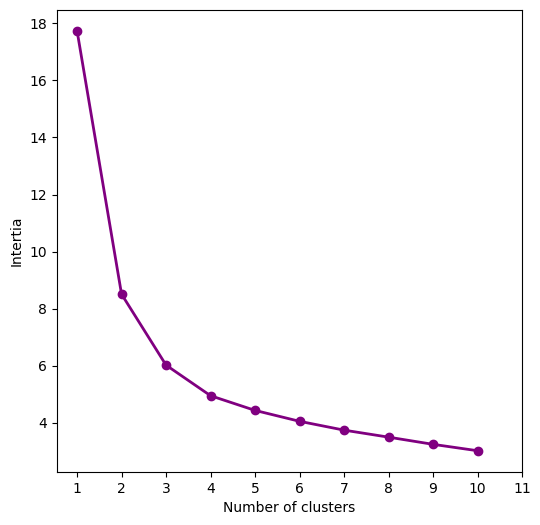

In [3]:
player_info_mf_only = player_info[player_info["Global Pos"] == "MF"]
features_mf_only = features[player_info["Global Pos"] == "MF"]

features_mf_only_scaled  = Normalizer().fit_transform(features_mf_only)

plot_cluster_intertia(features_mf_only_scaled)

### Count by Clusters

<Axes: ylabel='count'>

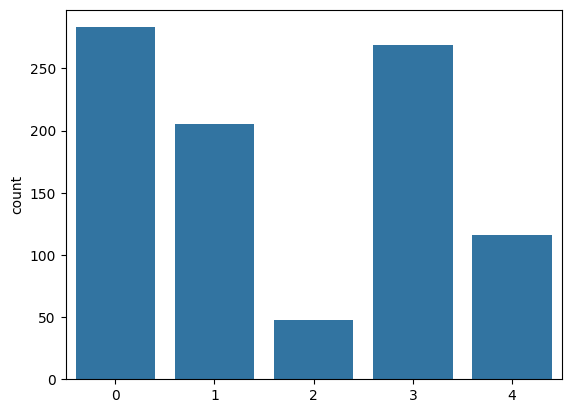

In [4]:
model = KMeans(n_clusters = 5, init = "k-means++", max_iter = 300, n_init = 20, random_state = 42)
labels = model.fit_predict(features_mf_only_scaled)

sns.countplot(x=np.array(labels))

### Label count by Position

<Axes: xlabel='labels', ylabel='proportion'>

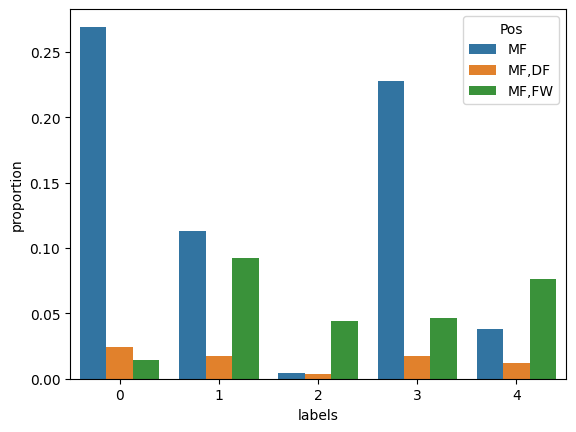

In [5]:
df_eval = pd.DataFrame({
    'labels': labels,
    'player': player_info_mf_only['Player'],
    'Pos': player_info_mf_only['Pos'],
    "Team" : player_info_mf_only["Team"],
    "Machtes":player_info_mf_only["Matches Played"]
})
sns.countplot(data=df_eval, x='labels', hue='Pos', stat="proportion")

In [29]:
# 0: DM, B-B
# 2: 6er (Spielmacher, Defensive Arbeit)
# 3: Offensive MF but less Matches played
# 4: Offensive MF
df_eval[df_eval['labels'] == 2].head(20)

,labels,player,Pos,Team,Machtes
Player,,,,,
Rodri,2,Rodri,MF,Manchester City,36.0
Thomas Partey,2,Thomas Partey,MF,Arsenal,33.0
Casemiro,2,Casemiro,MF,Manchester Utd,28.0
Bruno Guimarães,2,Bruno Guimarães,MF,Newcastle Utd,32.0
Fabinho,2,Fabinho,MF,Liverpool,36.0
Jordan Henderson,2,Jordan Henderson,MF,Liverpool,35.0
Moisés Caicedo,2,Moisés Caicedo,MF,Brighton,37.0
Douglas Luiz,2,Douglas Luiz,MF,Aston Villa,37.0
Pierre Højbjerg,2,Pierre Højbjerg,MF,Tottenham,35.0


In [7]:
df_eval[df_eval['labels'] == 4].head(20)

,labels,player,Pos,Team,Machtes
Player,,,,,
Cole Palmer,4,Cole Palmer,"MF,FW",Manchester City,14.0
Joe Willock,4,Joe Willock,MF,Newcastle Utd,35.0
Elliot Anderson,4,Elliot Anderson,"MF,FW",Newcastle Utd,22.0
Jeremy Sarmiento,4,Jeremy Sarmiento,MF,Brighton,9.0
Jacob Ramsey,4,Jacob Ramsey,"MF,FW",Aston Villa,35.0
Philippe Coutinho,4,Philippe Coutinho,"MF,FW",Aston Villa,20.0
Son Heung-min,4,Son Heung-min,"MF,FW",Tottenham,36.0
Richarlison,4,Richarlison,"MF,FW",Tottenham,27.0
Lucas Moura,4,Lucas Moura,"MF,DF",Tottenham,15.0


Label 5 shows players that have playing style of 6
- defensive, ... google typical six attributes

In [8]:
df_with_clusters = features_mf_only
df_with_clusters['Cluster'] = labels
cluster_summary = df_with_clusters.groupby('Cluster').mean()
cluster_summary

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_22492\689821685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_clusters['Cluster'] = labels


,Tackles_Att,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Interceptions,Clearances,Errors,Dribblers_Tkl_Succ,Dribblers_Tkl_Att,Dribblers_Tkl_Lost,...,Fls,Fld,Off,Crs,PKwon,PKcon,OG,Recov,Aerial Duels_Won,Aerial Duels_Lost
Cluster,,,,,,,,,,,,,,,,,,,,,
0,38.611307,16.600707,17.667845,4.342756,20.183746,24.522968,0.448763,17.759717,38.236749,20.477032,...,25.095406,18.314488,0.710247,31.021201,0.056537,0.215548,0.056537,115.985866,20.141343,19.233216
1,31.400000,11.990244,14.341463,5.068293,13.751220,13.648780,0.224390,13.224390,31.804878,18.580488,...,22.770732,25.921951,2.117073,36.473171,0.195122,0.087805,0.034146,96.014634,13.673171,18.121951
2,19.958333,8.333333,7.229167,4.395833,7.250000,7.145833,0.083333,8.666667,22.645833,13.979167,...,18.083333,23.395833,4.291667,29.583333,0.270833,0.145833,0.000000,65.020833,10.979167,18.375000
3,36.996283,14.739777,17.382900,4.873606,18.275093,19.676580,0.368030,16.873606,38.070632,21.197026,...,24.802974,23.739777,1.174721,31.063197,0.163569,0.230483,0.026022,115.710037,18.007435,19.059480
4,24.758621,8.991379,11.198276,4.568966,10.379310,8.913793,0.163793,10.189655,26.267241,16.077586,...,19.094828,23.939655,2.758621,38.663793,0.344828,0.129310,0.017241,78.232759,11.517241,17.439655


### Visualize

In [10]:
umap_3d = UMAP(n_components=3, init='random', random_state=42)
proj_3d = umap_3d.fit_transform(features_mf_only_scaled)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=labels
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Conclusion
Some clusters are capable to represent playing styles of certain midfielder.
<br>

__Possible Playing Styles__:
- defensive midfielder 
Abräumer: Ein robuster Spieler, dessen Hauptaufgabe es ist, den Ball vom Gegner zu erobern und den Angriff des Gegners zu unterbrechen.
Regisseur (Deep-Lying Playmaker): Ein defensiver Mittelfeldspieler, der das Spiel von hinten aufbaut und lange Pässe spielt
- central
Ein vielseitiger Mittelfeldspieler, der sowohl defensiv als auch offensiv agieren kann.
- central offensive midfielder
Dieser Spielertyp steuert das Offensivspiel des Teams, indem er Pässe, Assists und oft auch Tore vorbereitet.
- box-to-box midfielder
Ein Spieler, der sowohl offensiv als auch defensiv arbeitet und sich von einem Strafraum zum anderen bewegt. Dieser Spielertyp ist sehr laufstark und vielseitig
- winger
Ein Mittelfeldspieler, der an den Seitenlinien agiert und oft Flanken schlägt, Dribblings ansetzt oder versucht, den Ball in den Strafraum zu bringen. Dazu gehören klassische Winger wie Franck Ribéry oder Arjen Robben.
- wingback
Ein Mittelfeldspieler, der viel weiter vorne spielt als der klassische Außenverteidiger, aber sowohl defensive als auch offensive Aufgaben hat. Flügelverteidiger agieren meist in einem 3-5-2 oder 5-3-2 System. Beispiele wären Dani Alves oder Trent Alexander-Arnold.



__Detected Playing Styles__

- cluster 0: DM, B-B
- cluster 2: __6er__ (Spielmacher, Defensive Arbeit)
- cluster 3: Offensive MF but less Matches played
- cluster 4: __Offensive MF__

<br>

__Lessons Learned__:
It is crucial to also consider the event heat map of a player for clustering. That would improve the clustering a lot.
Some cluster were only concluded due to some players that are known for their playing style.

__Next Step__:
Use Regression, RF Classifer or other methods to see which parameters have more signifcants for each cluster

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest to assess feature importance for clustering
clf = RandomForestClassifier()
clf.fit(features_mf_only_scaled, labels)

# Get feature importance
feature_importances = pd.Series(clf.feature_importances_, index=features_mf_only.drop(columns=['Cluster'],axis=1).columns)
feature_importances.sort_values(ascending=False)


Carries_TotDist    0.211074
Carries_PrgDist    0.133591
Total_TotDist      0.090815
Carries_Number     0.066420
Carries_PrgC       0.052231
                     ...   
GCA Types_TO       0.001021
GCA Types_Fld      0.001008
PKwon              0.000835
2CrdY              0.000574
OG                 0.000260
Length: 86, dtype: float64

This gets the significants for all different labels, that are obviously different playing styles. 
So we have to get the importance by each label seperately. 

## Cluster on Latent Vector

### Optimize Clustering
PCA is used for latent vectors

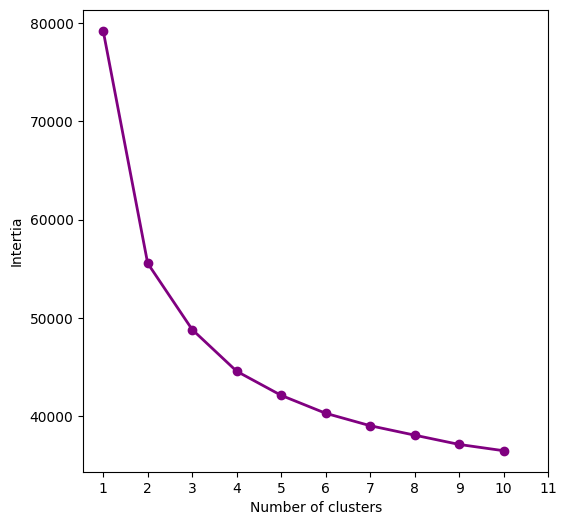

In [12]:
player_info_mf_only = player_info[player_info["Global Pos"] == "MF"]
features_mf_only = features[player_info["Global Pos"] == "MF"]

features_mf_only_scaled = StandardScaler().fit_transform(features_mf_only)
features_mf_only_scaled = PCA().fit_transform(features_mf_only_scaled)

plot_cluster_intertia(features_mf_only_scaled)

### Count by clusters

<Axes: ylabel='count'>

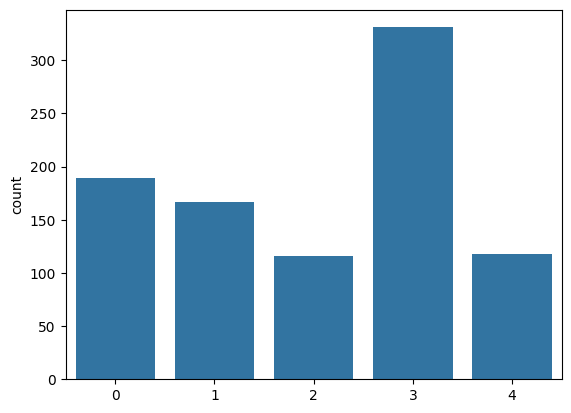

In [13]:
model = KMeans(n_clusters = 5, init = "k-means++", max_iter = 300, n_init = 30, random_state = 42)
labels = model.fit_predict(features_mf_only_scaled)

sns.countplot(x=np.array(labels))

### Label count by Position

<Axes: xlabel='labels', ylabel='proportion'>

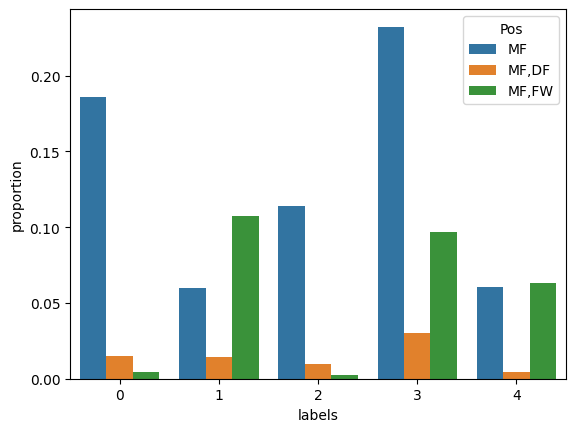

In [14]:
df_eval = pd.DataFrame({
    'labels': labels,
    'player': player_info_mf_only['Player'],
    'Pos': player_info_mf_only['Pos'],
    "Team" : player_info_mf_only["Team"],
    "Machtes":player_info_mf_only["Matches Played"]
})
sns.countplot(data=df_eval, x='labels', hue='Pos', stat="proportion")

In [33]:
# 0: 6er defensive
# 1: offensive (Olmo, Mount, Borre) but also unkown
# 2: 6er (Spielmacher, Defensive Arbeit)
# 3: fewer matches
# 4: Playmaker, Offensive, Dribbler
df_eval[df_eval['labels'] == 4].head(50)

,labels,player,Pos,Team,Machtes
Player,,,,,
Kevin De Bruyne,4,Kevin De Bruyne,MF,Manchester City,32.0
İlkay Gündoğan,4,İlkay Gündoğan,MF,Manchester City,31.0
Bernardo Silva,4,Bernardo Silva,"MF,FW",Manchester City,34.0
Martin Ødegaard,4,Martin Ødegaard,MF,Arsenal,37.0
Granit Xhaka,4,Granit Xhaka,MF,Arsenal,37.0
Bruno Fernandes,4,Bruno Fernandes,"MF,FW",Manchester Utd,37.0
Joe Willock,4,Joe Willock,MF,Newcastle Utd,35.0
Joelinton,4,Joelinton,"MF,FW",Newcastle Utd,32.0
Pascal Groß,4,Pascal Groß,"MF,DF",Brighton,37.0


### Visualize cluster

In [38]:
create_3d_plot(features_mf_only_scaled, player_info_mf_only["Player"])

### Conclusion

__Cluster Playing Styles__

- 0: 6er defensive
- 1: offensive (Olmo, Mount, Borre) but also unkown
- 2: 6er (Spielmacher, Defensive Arbeit)
- 3: fewer matches
- 4: Playmaker, Offensive, Dribbler

<br>

__Lessons Learned__:
- The label count by position plot looks a little bit more distinguished.
- clustering feel a bit more accurate to playing styles

__Next Step__:
- Use Regression, RF Classifer or other methods to see which parameters have more signifcants for each cluster
- Add heatmap